# Train UNet Architecture to predict UI segmentation

Now we've got data in a Dataset format ready to be processed as tensors by a neural net.

The code for the full lightning module, model, dataset, and transforms can be found in the `ui_segmentation_system.py` file

We'll be using [pytorch lightning](https://pytorch-lightning.readthedocs.io/en/latest/introduction_guide.html), an open-source package whose goal is to organize your pytorch code and take away a lot of the boiler plate code needed to run loops and do logging. 

It'll do a lot of things auto-magically for us, but we'll still be writing the core training logic of our prediction network. It also gives us a lot of powerful training flags out of the box, such as profiling, early stopping, gradient accumulation, model weights summary, and access to a handful of popular logging frameworks.

[All Pytorch Lightning traning flags](https://pytorch-lightning.readthedocs.io/en/latest/trainer.html#trainer-class)

In [1]:
#Jupyter Notebook Specific
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
print(f"matplotlib loaded: {matplotlib.__version__}")

matplotlib loaded: 3.2.1


In [2]:
import os
import glob
import logging as log
import json
import time
import datetime
from collections import namedtuple
from typing import Tuple
import argparse

import PIL
from PIL import Image

import numpy as np

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import pytorch_lightning

import ui_segmentation_system as UI_SEG
print(f"torch {torch.__version__}, torchvision {torchvision.__version__}, PIL {PIL.__version__}, pytorch-lightning {pytorch_lightning.__version__} loaded")

torch 1.4.0, torchvision 0.5.0, PIL 7.1.1, pytorch-lightning 0.7.1 loaded
torch 1.4.0, torchvision 0.5.0, PIL 7.1.1, pytorch-lightning 0.7.1 loaded


# 1. Lightning Module

This contains all the information for what model to use, what dataset to use, how to treat each batch, and any important metrics or images to log

In [3]:
class UISegmentationSystem(pytorch_lightning.LightningModule):
    """
    Predict UI segments of videogame screenshots using a Convolutional Neural Network.
    This class can be used for training, validation, and prediction.
    """
    def __init__(self, hparams):
        """
        Requires args for batch size, data folder, output folder, etc.
        """
        super(UISegmentationSystem, self).__init__()
        log.info("Running __init__")
        self.hparams = hparams
        # I usually initialize like this to use it as a boolean condition elsewhere
        self.dataset = None
        # We could use any kind of network architecture, or set it via an arg flag
        self.network = UI_SEG.UNet(num_in_channels=3, num_out_channels=1, max_features=256)

        self.models_dir = f"{hparams.output_dir}/model_checkpoints"
        self.images_dir = f"{hparams.output_dir}/step_images"
        os.makedirs(self.models_dir, exist_ok=True)
        os.makedirs(self.images_dir, exist_ok=True)

    
    def forward(self, input):
        """
        Send an input image (tensor with batch dimension) through the prediction network and return the prediction (tensor with same batch dimension)
        This is the same as the forward method of a pytorch nn module, we just have our network in a seperate file to have fewer lines here
        """
        return self.network(input)

    # ---------------------
    # TRAINING SETUP
    # ---------------------
    def configure_optimizers(self):
        """
        REQUIRED
        Adam is a pretty popular optimizer, we'll use it
        Lightning handles the zero_grad() and step() calls
        :return: optimizer to use in training 
            (optionally return list of optimizers and a list of learning rate schedulers in a tuple)
        """
        log.info("Configuring optimizer")
        optimizer = torch.optim.Adam(
            self.network.parameters(),
            lr=self.hparams.learning_rate
        )
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
        #     factor=0.1)
        # return [optimizer], [scheduler]
        return optimizer
    
    def prepare_data(self):
        """
        REQUIRED
        Lightning calls this once at the beginning of training / inference, it gets called once no matter how many GPUs you're using
        """
        # Resize to square and turn PIL image into torch Tensor
        training_transform = UI_SEG.ImageTargetCompose([
            UI_SEG.ImageTargetResize((self.hparams.image_size, self.hparams.image_size)),
            UI_SEG.ImageTargetToTensor()
        ])
        log.info('Prepped training transform')
        self.dataset = UI_SEG.UIImageMaskDataset(data_dir=self.hparams.dataset, transform=training_transform, overfit_num=self.hparams.overfit_num)

        self.val_dataset = UI_SEG.UIImageMaskDataset(data_dir=self.hparams.dataset, transform=training_transform, overfit_num=self.hparams.overfit_num)
        
        log.info(
            f'Train ({len(self.dataset)} samples) and Val ({len(self.val_dataset)} samples) datasets loaded')
        
        # Configure val set with 20% of full data. or do k-fold, up to you
        # num_samples = len(self.dataset)
        # num_train = int(0.8 * num_samples)
        # indices = torch.randperm(num_samples).tolist()
        # self.dataset = torch.utils.data.Subset(
        #     self.dataset, indices[0:num_train])
        # self.val_dataset = torch.utils.data.Subset(
        #     self.val_dataset, indices[num_train:])
        # log.info(f'Full Dataset loaded: len: {num_samples}')
    
    def train_dataloader(self):
        """
        REQUIRED. Return pytorch dataloader to be used in training loop
        Lightning passes batches to the `training_step()` function below. 
        It also handles making a distributed sampler if you're using multiple GPUs.
        """
        log.info("Fetching training dataloader")
        return torch.utils.data.DataLoader(self.dataset, batch_size=self.hparams.batch_size, drop_last=True, shuffle=True)
    
    def val_dataloader(self):
        """
        REQUIRED if doing val loop. Return pytorch dataloader to be used in validation loop
        Lighting passes each batch to the `validation_step()` function below.
        """
        log.info("Fetching validation dataloader")
        # Batch_size increase if using a full val set
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=1, shuffle=False)

    def loss_function(self, targets, predictions):
        """
        Used in training and validation to backpropogate into the network weights and assess how well our model is doing.
        Combines sigmoid with Binary Cross Entropy for numerical stability.
        Can include pos_weight to increase recall of underrepresented classes
        :param targets: ground truth segmentation mask
        :param predictions: output of the network
        """
        bce_loss = F.binary_cross_entropy_with_logits(predictions, targets)
        return bce_loss

    # -----------------------------
    # TRAINING LOOP
    # -----------------------------
    def training_step(self, batch, batch_idx):
        """
        Lightning calls this inside the training loop
        :param batch: Lightning yields a batch from the dataloader, in our case it is a tuple of (images, targets) already batched (tensors of dimesions [Batch, Channels, Height, Width])
        :param batch_idx: batch_number in current epoch
        :return: dict
            - loss -> tensor scalar [REQUIRED]
            - progress_bar -> Dict for progress bar display. Must have only tensors
            - log -> Dict of metrics to add to logger. Must have only tensors (no images, etc)
        """
        # forward pass
        images, targets = batch
        predictions = self.forward(images)
        # calculate loss
        loss_val = self.loss_function(targets, predictions)
        to_log = {'training_loss': loss_val}
        output = {
            'loss': loss_val,  # required
            'progress_bar': to_log,
            'log': to_log,
        }

        return output

    # ---------------------
    # VALIDATION LOOP
    # ---------------------
    
    def validation_step(self, batch, batch_number):
        """
        Called in validation loop with model in eval mode
        :param batch: Lightning yields a batch from the dataloader, in our case it is a tuple of (images, targets) already batched (tensors of dimesions [Batch, Channels, Height, Width])
        :param batch_number: Lightning tells us what batch number we're on. We'll use this to choose when to log some images
        :return: dict
            - val_loss -> tensor scalar [Useful for Early Stopping]
            - progress_bar -> Dict for progress bar display. Must have only tensors
            - log -> Dict of metrics to add to logger. Must have only tensors (no images, etc)
        """
        images, targets = batch
        predictions = self.forward(images)
        loss_val = self.loss_function(targets, predictions)
        if batch_number == 0:
            self.log_validation_images(images, predictions, targets, step=self.global_step)
        to_log = {'val_loss': loss_val}
        output = {
            'val_loss': loss_val,
            'progress_bar': to_log,
            'log': to_log
        }
        return output

    def log_validation_images(self, inputs, predictions, targets, step=0):
        # Turn 1 channel binary masks into 3 channel 'rgb' 
        model_outputs = torch.cat((predictions, predictions, predictions), dim=1)
        viz_targets = torch.cat((targets, targets, targets), dim=1)
        img_grid = torchvision.utils.make_grid(torch.cat([inputs, model_outputs, viz_targets]), nrow=inputs.shape[0], padding=20, normalize=True, range=(0,1))

        plt.imshow(np.asarray(img_grid.detach().permute((1,2,0)).cpu()))
        torchvision.utils.save_image(img_grid, os.path.join(self.images_dir, f"step_{step}_val_batch.png"))



# 2. Setup Training

We'll want to be able to set different arguments for our training with either the command line or programatically

This is an overfit example using the Pytorch Lightning `Trainer` to do all the looping for us. 

Note that Lightning uses early stopping by default conditioned on `val_loss`, this can be changed or `max_epochs` can be limited.

INFO:root:Running __init__
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:Prepped training transform
INFO:root:Train (100 samples) and Val (100 samples) datasets loaded
INFO:root:Configuring optimizer
INFO:root:
  | Name    | Type | Params
-----------------------------
0 | network | UNet | 1 M   
INFO:root:Fetching validation dataloader
INFO:root:Fetching training dataloader
INFO:root:Fetching validation dataloader
Epoch 1:  80%|████████  | 100/125 [00:01<00:00, 69.42it/s, loss=0.851, training_loss=0.851, v_num=1]
Epoch 1: : 150it [00:01, 88.18it/s, loss=0.519, training_loss=0.413, v_num=1]
Epoch 2:  80%|████████  | 100/125 [00:01<00:00, 83.01it/s, loss=0.515, training_loss=0.41, v_num=1]
Epoch 2: : 150it [00:01, 102.55it/s, loss=0.449, training_loss=0.349, v_num=1]
Epoch 3:  80%|████████  | 100/125 [00:01<00:00, 92.17it/s, loss=0.447, training_loss=0.347, v_num=1]
Epoch 3: : 150it [00:01, 113.91it/s, loss=0.406, training_loss=0.297, v_num=1]
Epoch 4:  80

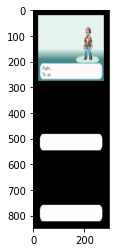

In [7]:
from argparse import Namespace
def setup_and_train():
    # ------------------------
    # 0 SETUP
    # ------------------------
    log.getLogger().setLevel(log.INFO)

    parser = argparse.ArgumentParser(
        description='UI Segmentation Training')
    parser = pytorch_lightning.Trainer.add_argparse_args(parser)
    # data
    parser.add_argument('-d', '--dataset',
                        default=os.path.join('.', 'test_inputs'), type=str)
    parser.add_argument("-o", "--output-dir", type=str, default="./test_outputs", help="where to save validation images from training")
    
    parser.add_argument('-b', '--batch-size', default=4, type=int)
    parser.add_argument('-lr', '--learning-rate', default=0.001, type=float,
                        help='initial learning rate')
    parser.add_argument("--image-size", type=int, default=256,
                        help="size of training images, default is 256")
    parser.add_argument("--overfit-num", type=int, default=0,
                        help="Set to positive number to overfit on one image, default is 0 (no overfitting)")

    parser.add_argument("--seed", type=int, default=4747, help="random seed")
    
    # args = parser.parse_args()
    args = Namespace(**{
        'dataset': './test_inputs',
        'output_dir': './test_outputs',
        'batch_size': 4,
        'learning_rate': 0.001,
        'image_size': 256,
        'overfit_num': 100,
        'seed': 4747
    })
    ui_predictor = UISegmentationSystem(args)
    trainer = pytorch_lightning.Trainer(default_save_path=args.output_dir, progress_bar_refresh_rate=50, gpus='0', profiler=True, weights_summary='top', max_epochs=5)
    trainer.fit(ui_predictor)
setup_and_train()

# 3. Visualize results

In the validation loop we set it to save a batch of pngs every epoch (when we get the first batch on an epoch) to a folder.

Here we fetch all those files, sorted by modification time so that the first comes first and last comes last (glob doesn't sort things in a reliable order depending on OS), save a gif of the training and a copy of the last prediction to our outputs folder

In [20]:
import imageio
gif_images = []
file_paths = glob.glob(f"./test_outputs/step_images/*")
file_paths = sorted(file_paths, key=os.path.getmtime)
print(file_paths)
for step_img in file_paths:
    gif_images.append(imageio.imread(step_img))
num_frames = len(gif_images)
duration = num_frames * 0.1
imageio.mimsave("./test_outputs/val_outputs.gif", gif_images, duration=duration)
imageio.imsave("./test_outputs/final_output.png", gif_images[-1])

['./test_outputs/step_images/step_0_val_batch.png', './test_outputs/step_images/step_24_val_batch.png', './test_outputs/step_images/step_49_val_batch.png', './test_outputs/step_images/step_74_val_batch.png', './test_outputs/step_images/step_99_val_batch.png', './test_outputs/step_images/step_124_val_batch.png']


# Using HTML to display gif

If this doesn't work, you can view in the files

<img src="./test_outputs/val_outputs.gif"/>